# Extracting the most centered feature
In this notebook, I will demonstrate my own algorithm for extracting the most centered feature. A feature is defined as a coherent group of pixels. 

To simplify, in the data pipeline, the Sudoku board is divided into 81 images. Then, for each image, the most centered feature is cropped and centered in image. My solution to finding the most centered feature can be explained in two parts.
1. Go through all pixels to create features, each feature get assigned a number
2. Expand a search from the middle and stop as soon as a pixel belonging to a feature is found.

In this notebook we will look at these two parts and visualize how this works. Please run this notebook yourself to see the animations that visualizes the algorithms. The first one is, unfortunately, a little bit slow but nevertheless, I believe that it illustrates the algorithm quite well. We end this example-notebook with showing how the data pipeline proceeds after extracting the most centered feature.

In this example notebook, we will not focus on the code but on the visualizations to try to get a feeling on how the algorithms work. For any code related question, I strongly suggest looking at the source code in \project\PreprocessNumber.py at https://github.com/EmpanS/Project-Sudoku. 

Finally, remember to restart the kernel before running a block of code containing an animation, otherwise the animations might fail (I've added all the imports needed in each block).

# Part 1 - Identify all features

Part 1 is all about identifying all features. This is done by an algorithm which goes through each pixel from top to bottom, left to right. If a non-black pixel is found, the pixel should be part of a feature. We have four different cases:

(The coherent pixels are the pixel to the left and the pixel above.)
1. No coherent pixels are part of a feature:
    - the pixel will be the beginning of a new feature. 
2. Only one of the coherent pixels is part of a feature:
    - the pixel joins that feature. 
3. Both coherent pixels are part of the same feature
    - the pixel joins that feature. 
4. The coherent pixels are part of different features:
    - the pixel joins the feature of the pixel to the left. All pixels assigned to the feature of the pixel above joins the feature of the pixel to the left.

In the source code, each feature is represented by a number, but for illustrations sake, we will use colors instead.

In [ ]:
# Install useful dependencies
!pip3 install numpy==1.16.4
!pip3 install --upgrade matplotlib
!pip3 install --upgrade opencv-python

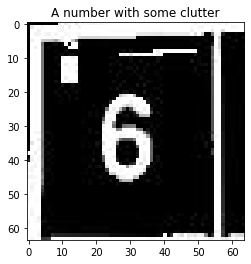

In [1]:
# Import useful libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# We will look at a typical image (one of the 81 images from the data pipeline). This one contains a number.
number = cv2.imread("example_number_1.jpg", cv2.IMREAD_GRAYSCALE)
plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(number, cmap='gray')
plt.title("A number with some clutter")
plt.show()

In the picture above we can see many different features, remember that a feature is a group of coherent non-black pixels. For example, the number 6 is one feature (which we want to extract!), the rectangle in the upper left is another as well as the thin-line in the upper right and the straight lines forming the grid. 

Now, we want to assign a group color to each feature. We can do this by following the instructions above, that is looping through all pixels and following the four cases specified above. Remember to restart the kernel before running the code block below to ensure that the animation works. 

<IPython.core.display.Javascript object>


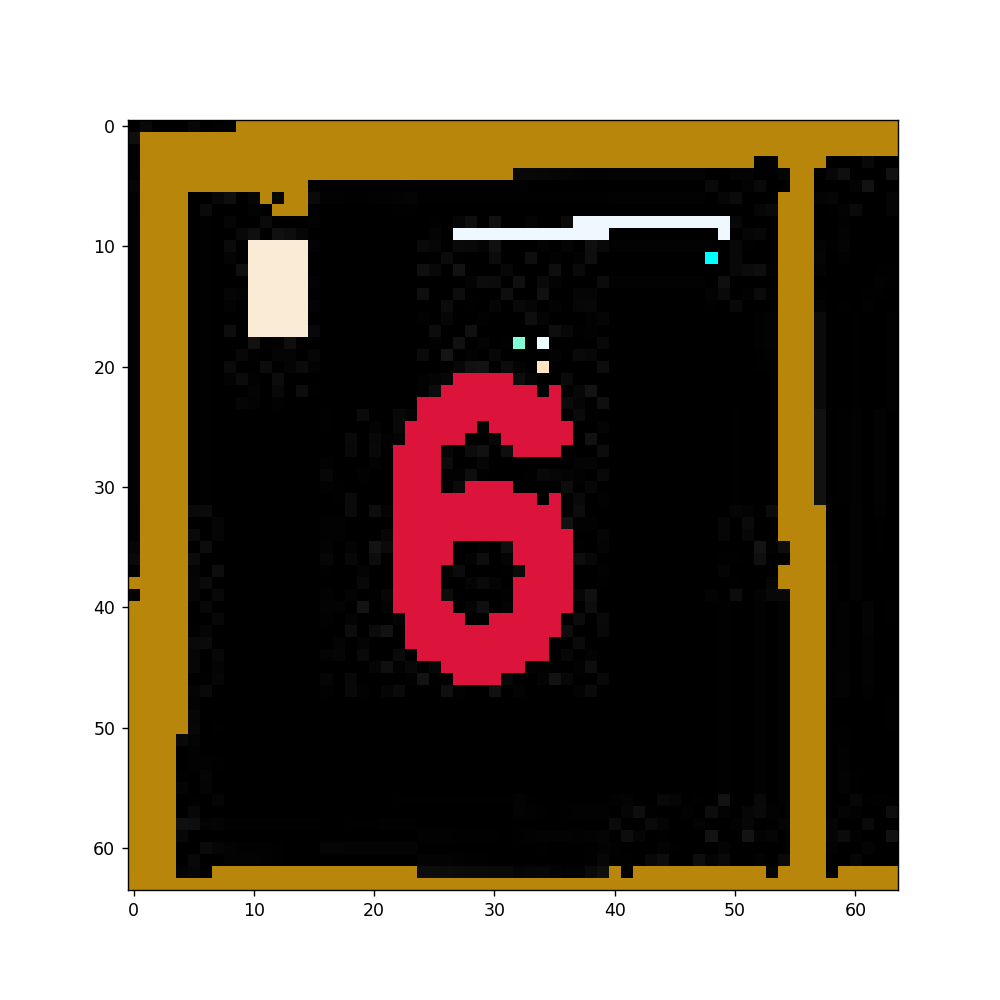

In [1]:
# This is not the whole class used in PreprocessNumber.py, but only with two manipulated methods.

# Import useful libraries
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import cv2
import numpy as np
from matplotlib import colors as mcolors

# Using colors to ease the visualization
color_dict = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = []
for color in color_dict:
    # Avoiding some problematic colors (that blends in)
    if color in ['k', 'w', 'b', 'beige']:
        continue
    colors.append(color)

# Initialize plot
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.gca()
fig.show()
    

class PreprocessNumber:
    def __init__(self, image):
        self.NOT_BLACK_THRESHOLD = 20
        self.image = image
        self.extracted_feature = np.zeros_like(self.image)
        self.dimension = self.image.shape
        self.__dct_groups = {}

    def __check_left_and_above_pixel_for_group(self, pixel_coord):
        group_pixel_left = -1
        if pixel_coord[1] > 0:
            # If there is an adjacent pixel to the left
            group_pixel_left = self.__dct_groups[str(pixel_coord[0]) + ":" + str(pixel_coord[1]-1)]
        if pixel_coord[0] > 0:
            # If there is an adjacent pixel above
            group_pixel_above = self.__dct_groups[str(pixel_coord[0] - 1) + ":" + str(pixel_coord[1])]
            if group_pixel_left == -1:
                return group_pixel_above
            elif group_pixel_above == -1:
                return group_pixel_left
        else:
            # No adjacent pixel above, return the group of the pixel to the left
            return group_pixel_left
        
        if group_pixel_left != group_pixel_above:
            # Replacing pixels belonging to the group of the pixel above to the group of the pixel to the left
            for item in self.__dct_groups:
                if self.__dct_groups[item] == group_pixel_above:
                    self.__dct_groups[item] = group_pixel_left
                    # Add color 
                    color_idx = self.__dct_groups[item]
                    color = mcolors.hex2color(colors[color_idx])
                    rgb_color = [color[i] * 255 for i in range(len(color))]
                    parts = item.split(":")
                    row = int(parts[0])
                    col = int(parts[1])
                    rgb_number[row][col] = rgb_color
            # Update plot        
            color = mcolors.hex2color(colors[color_idx])
            rgb_color = [color[i] * 255 for i in range(len(color))]
            rgb_number[row][col] = rgb_color
            plt.clf()
            plt.imshow(rgb_number)
            fig.canvas.draw()
        return group_pixel_left
    
    def create_groups_of_features(self):
        new_group = 0
        for row in range(self.dimension[0]):
            for col in range(self.dimension[1]):
                if self.image[row][col] > self.NOT_BLACK_THRESHOLD:
                    # Checks if the current pixel at (row, col) is adjacent to already assigned non-black pixels.
                    surrounding_group = self.__check_left_and_above_pixel_for_group(pixel_coord=[row, col])
                    if surrounding_group != -1:
                        self.__dct_groups[str(row) + ":" + str(col)] = surrounding_group
                    else:
                        self.__dct_groups[str(row) + ":" + str(col)] = new_group
                        new_group += 1
                else:
                    self.__dct_groups[str(row) + ":" + str(col)] = -1
                color_idx = self.__dct_groups[str(row) + ":" + str(col)]
                if color_idx != -1:
                    # Update plot
                    color = mcolors.hex2color(colors[color_idx])
                    rgb_color = [color[i] * 255 for i in range(len(color))]
                    rgb_number[row][col] = rgb_color
                    plt.clf()
                    plt.imshow(rgb_number)
                    fig.canvas.draw()
                    
rgb_number = cv2.imread("example_number_1.jpg")
number = cv2.imread("example_number_1.jpg", cv2.IMREAD_GRAYSCALE)
preprocess_number = PreprocessNumber(number)
preprocess_number.create_groups_of_features()

As we can see in the animation above, all features gets assigned a color (a number in the source code). Since all pixels in a feature gets assigned the same color, we can use this color to find all pixels of that feature. 

Next, we have part 2 where we will find the most centered feature.

# Part 2 - Find the most centered feature

To find the most centered feature I came up with a search algorithm that starts at the center of an image and then expands outwards. Once again, this algorithm is most easily understood by looking at an animation. Once a non-black pixel is found, the algorithm register what color (or number in the source code) the feature has been assigned, then stops the search. 

First, we look at how the search algorithm works by running it on a black image, then we run it on an image with a number. Remember to restart the kernel before running the animations. 

<IPython.core.display.Javascript object>


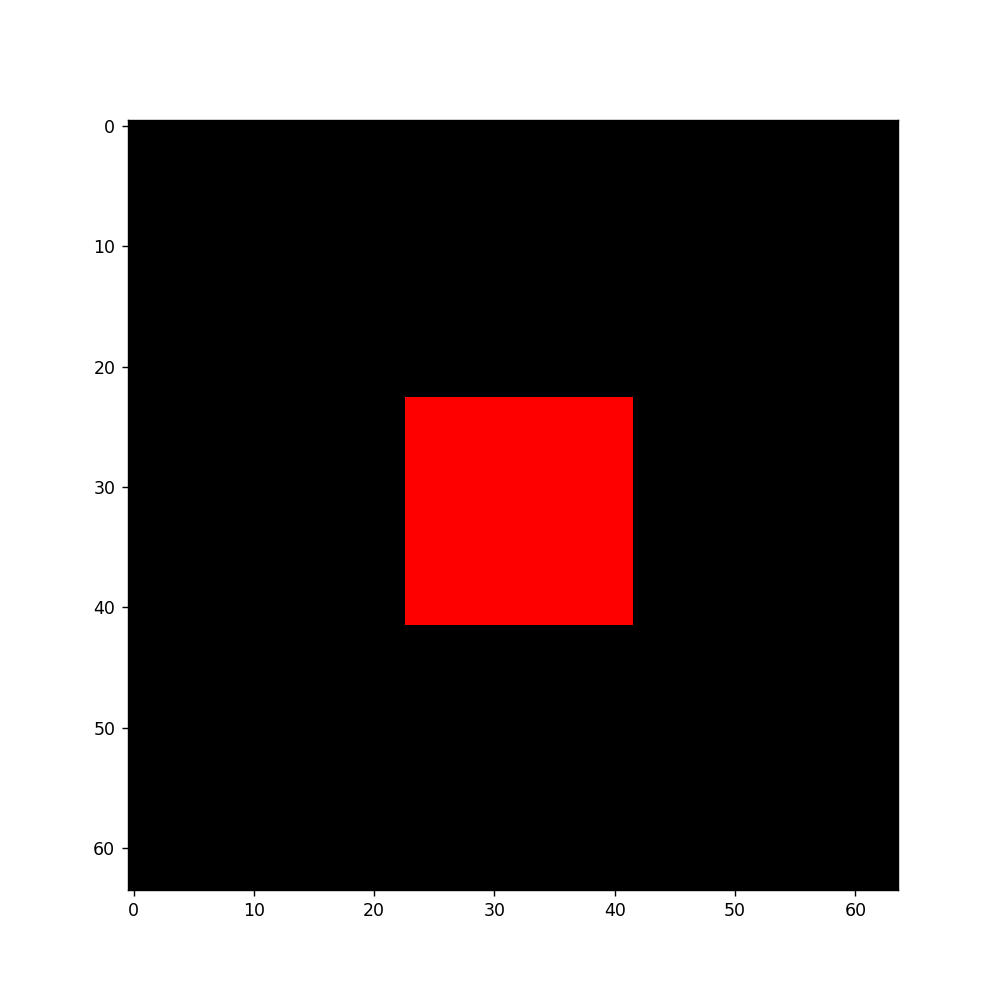

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import cv2
import pylab as pl
import numpy as np

# Initialize plot
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.gca()
fig.show()

def visualize_search_algorithm(image):
    dimension = image.shape
    NOT_BLACK_THRESHOLD = 20
    center_row = int(dimension[0] / 2)
    center_col = int(dimension[1] / 2)
    nr_search_loops = 10
    loop_directions = [[0, 1], [1, 0], [0, -1], [-1, 0]]

    # Starts searching from the middle
    image[center_row][center_col] = [255, 0, 0]
    plt.imshow(image)
    fig.canvas.draw()
    for loop_nr in range(1, nr_search_loops):
        center_row -= 1
        center_col -= 1
        search_coord = [center_row, center_col]
        for direction in loop_directions:
            vertical = direction[0]
            horizontal = direction[1]
            for i in range(loop_nr * 2):
                # Update plot
                image[search_coord[0]][search_coord[1]] = (255, 0, 0)
                plt.clf()
                plt.imshow(image)
                fig.canvas.draw()
                search_coord[0] += 1 * vertical
                search_coord[1] += 1 * horizontal

rgb_number = cv2.imread("example_number_1.jpg")
visualize_search_algorithm(np.zeros_like(rgb_number))

We can cleary see how the search algorithm (represented by the red color above) starts in the center and then expands outwards, looking at one pixel at the time. As soon as it finds a non-black feature it stops as shown in the animation below. Remember to restart the kernel before running the animation.

<IPython.core.display.Javascript object>


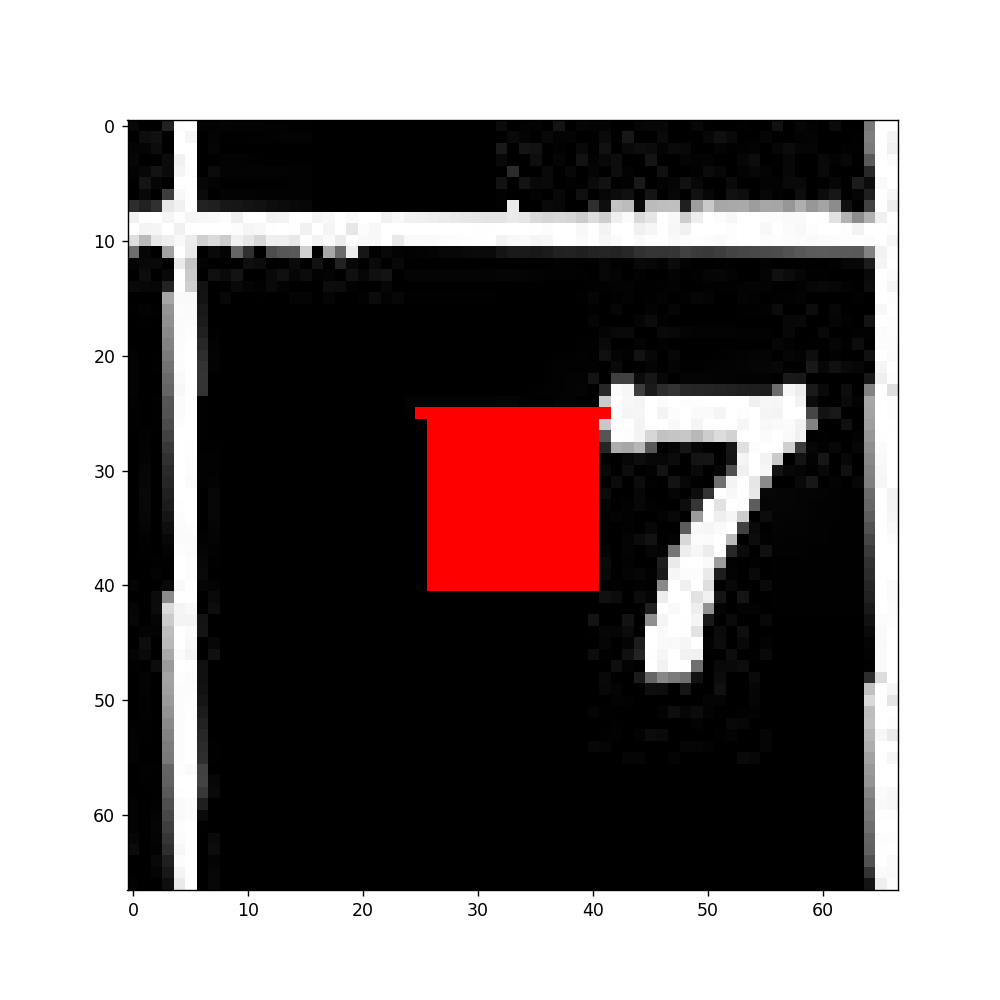

Found a feature!


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import cv2
import pylab as pl
import numpy as np

def find_centered_feature(image):
    dimension = image.shape
    NOT_BLACK_THRESHOLD = [70, 70, 70]
    center_row = int(dimension[0] / 2)
    center_col = int(dimension[1] / 2)
    nr_search_loops = 10
    loop_directions = [[0, 1], [1, 0], [0, -1], [-1, 0]]

    # Starts looking at the centered pixel
    image[center_row][center_col] = [255, 0, 0]
    plt.imshow(image)
    fig.canvas.draw()
    if np.all(image[center_row][center_col] > NOT_BLACK_THRESHOLD):
        return True
    else:
        for loop_nr in range(1, nr_search_loops):
            center_row -= 1
            center_col -= 1
            search_coord = [center_row, center_col]
            for direction in loop_directions:
                vertical = direction[0]
                horizontal = direction[1]
                for i in range(loop_nr * 2):
                    if np.all(image[search_coord[0]][search_coord[1]] > NOT_BLACK_THRESHOLD):
                        # Update plot
                        image[search_coord[0]][search_coord[1]] = (255, 0, 0)
                        plt.clf()
                        plt.imshow(image)
                        fig.canvas.draw()
                        return True
                    # Update plot
                    image[search_coord[0]][search_coord[1]] = (255, 0, 0)
                    plt.clf()
                    plt.imshow(image)
                    fig.canvas.draw()
                    search_coord[0] += 1 * vertical
                    search_coord[1] += 1 * horizontal
    return False

# Initialize plot
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.figure()
ax = fig.gca()
fig.show()

rgb_number = cv2.imread("example_number_2.jpg")

if(find_centered_feature(rgb_number)):
    print("Found a feature!")

In the animation above, we see that the algorithm stops the search when it has found a feature (the number seven, which we want to extract in this case!). Then the indices can be used to find the assigned number to the current Feature, which in turn can be used to extract all pixels belonging to that feature.

## Next in the data pipeline
In each one of the 81 images, the most centered feature gets extracted and put in another image which gets analyzed based on two conditions to determine if the extracted feature is a number. I tried many different conditions, but what I found worked best was the following two conditions:

An image contains a number if:
1. The middle square contains at least five non-black pixels, assuming that the image containing a potential number is split into a 3x3-grid with 9 squares of equal size.
2. The extracted feature have at least 25 non-black pixels.

If the image contains a number given these conditions, the image is added to a list, if not, a black image with the same dimension is added to the list instead. This creates a list containing 81 clean images as shown below. 

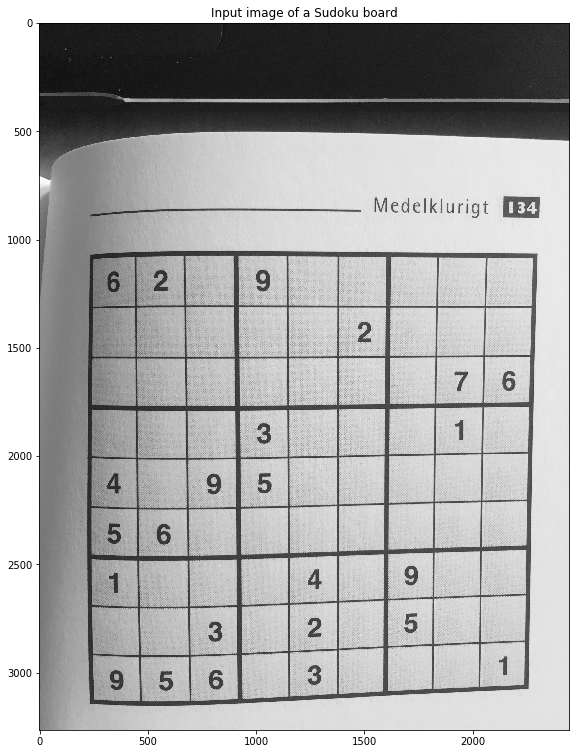

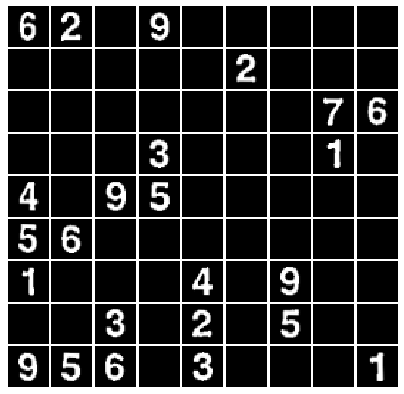

In [1]:
# Importing useful libraries
import sys
import os
import os.path as path
# Appending the project and example-folder to path
sys.path.append(path.abspath(path.join(os.getcwd(),"../..")) + "/project")
from SudokuSolver import SudokuSolver
from Preprocess import *
import matplotlib.pyplot as plt
%matplotlib inline

MNIST_DIMENSION = (28, 28)

# Visualizing image before entering the data pipeline
sudoku_img = cv2.imread("example_1.jpg", cv2.IMREAD_GRAYSCALE)
plt.rcParams['figure.figsize'] = [13, 13]
plt.imshow(sudoku_img, cmap='gray')
plt.title("Input image of a Sudoku board")
plt.show()

# Entering the data pipeline
resized_sudoku_img = cv2.resize(sudoku_img, (1200, 900), interpolation=cv2.INTER_AREA)
processed_sudoku_img = preprocess_sudoku_board(resized_sudoku_img.copy(), MNIST_DIMENSION)

def plot_81_images(images):
    fig = plt.figure(figsize=(7,7))
    plt.axis('off')
    counter = 0
    for i in range(1,10):
        for j in range(1, 10):
            fig.add_subplot(9, 9, counter+1)
            plt.imshow(images[counter][0], cmap='gray')
            plt.axis('off')
            counter += 1
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Now we visualize the image after going through the data pipeline using the function plot_81_images
plot_81_images(processed_sudoku_img)

As we can see in the plot above, the data pipeline prepares the images to be put into the model.